In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr,spearmanr
from matplotlib.patches import Patch
import pickle
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn import svm, preprocessing, pipeline
import sklearn.linear_model as LM
from sklearn.feature_selection import VarianceThreshold
from lightgbm import LGBMRegressor, early_stopping
import lightgbm as lgb
from sklearn.model_selection import RepeatedKFold
from sklearn import preprocessing

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['font.family'] = ['arial']
matplotlib.rcParams['font.size'] = 6

sns.set_theme(context ='paper', 
    palette="Paired", 
    style='white',
    font='arial',
    font_scale=1.0)

In [3]:
from load_data_from_synpase import *
from load_data import AMLData, load_drug_response, cluster_colors, data_colors

Welcome, James Pino!




UPGRADE AVAILABLE

A more recent version of the Synapse Client (2.7.0) is available. Your version (2.6.0) can be upgraded by typing:
    pip install --upgrade synapseclient

Python Synapse Client version 2.7.0 release notes

https://python-docs.synapse.org/build/html/news.html


UPGRADE AVAILABLE

A more recent version of the Synapse Client (2.7.0) is available. Your version (2.6.0) can be upgraded by typing:
    pip install --upgrade synapseclient

Python Synapse Client version 2.7.0 release notes

https://python-docs.synapse.org/build/html/news.html



Welcome, James Pino!



In [4]:
def load_q_treated():
    q_proteomics = load_table('syn23595222')
    q_proteomics['label'] = q_proteomics['Gene'] + '_prot'
    proteomics_mapper = {
        'Gene': 'identifier',
        'value': 'exp_value',
    }
    q_proteomics.rename(proteomics_mapper, axis=1, inplace=True)
    
    q_phospho = load_table('syn23595223')
    
    phosp_mapper = {
            'Gene': 'gene_symbol',
            'site': 'label',
            'value': 'exp_value',
        }
    q_phospho.rename(phosp_mapper, axis=1, inplace=True)
    
    quiz_data = pd.concat([q_phospho, q_proteomics])

    quiz_data.loc[quiz_data['cellLine'] == 'MOLM14', 'cellLine'] = 'Naive'
    quiz_data.loc[quiz_data['cellLine'] == 'EARLY Quizartinib Resistance MOLM14', 'cellLine'] = 'Early'
    quiz_data.loc[quiz_data['cellLine'] == 'LATE Quizartinib Resistance MOLM14', 'cellLine'] = 'Late '
    quiz_data.loc[quiz_data['cellLine'] == 'RESISTANT MOLM14', 'cellLine'] = 'Resistant'
    
    quiz_data['sample_id'] = quiz_data['Sample'] + '_' + \
                             quiz_data['Ligand'] + '_' + \
                             quiz_data['cellLine']
    
    qd = quiz_data.pivot_table(
        index='sample_id',
        columns='label', 
        values='exp_value'
    )
    return qd

def align_cell_line_to_patients(patient, cell_line):
    patient_ids = set(patient.columns.values)
    cell_line_ids = set(cell_line.columns.values)
    in_both = patient_ids.intersection(cell_line_ids)
    merged = pd.concat([patient, qd[in_both]])
    cell_line_labels = cell_line.index.values
    patient_labels = patient.index.values
    return merged, cell_line_labels, patient_labels

In [5]:
# point of access for all data
data = AMLData()
qd = load_q_treated()

significant not in columns.
p_value not in columns.
Loading syn23595222
Loading syn23595223


In [6]:
data.drug_names

In [7]:
good_param = dict(
    device_type='cpu',
    boosting_type='gbdt',
    num_threads=4,
    n_jobs=None,
    objective = 'regression',
    metric='rmse',
    lambda_l1=10,
    lambda_l2=1,
    reg_alpha=None,
    reg_lambda=None,
    learning_rate=.1,
    tree_learner='serial',
    max_bin=63,
    num_leaves=21,
    max_depth=5,

    feature_fraction=.8, #.8

    bagging_freq=1,
    bagging_fraction=.5,
    subsample=None,
    subsample_freq=None,
    
    min_child_weight=0.2,
    min_data_in_leaf=2,
    min_child_samples=None,
    min_gain_to_split=None,
    colsample_bytree=None,
    min_split_gain=None,
    n_estimators=10000,
    verbose=-1,
    deterministic=True,
    random_state=10,

)

In [8]:
# parameters used
good_param = dict(
    device_type='cpu',
    boosting_type='rf',
    num_threads=8,
    n_jobs=None,
    objective='regression',
    metric='rmse',
    lambda_l1=1000,
    lambda_l2=0,
    reg_alpha=None,
    reg_lambda=None,
    learning_rate=.01,

    max_bin=256,
    num_leaves=7,  # 21
    max_depth=5,  # -1


    feature_fraction=1,  # .8

    bagging_freq=1,
    bagging_fraction=.9,
    subsample_freq=None,
    subsample=None,
    
#     min_child_weight=0.2,
    min_data_in_leaf=5,
    min_child_samples=None,
    colsample_bytree=None,
    min_split_gain=None,
    n_estimators=10000,
    verbose=-1,
    deterministic=True,
    random_state=10,

)

In [9]:
def run_gbt(x_train, y_train, x_test, y_test, cell_line, feature_names):
#     good_param['min_data_in_leaf'] = int(np.ceil(x_train.shape[0] * .1))
    eval_metric = 'rmse'
    model_name = 'gbt'

    lgb_model = lgb.LGBMRegressor(**good_param)
    lgb_model.fit(
        x_train, y_train,
        callbacks=[lgb.early_stopping(
            1000, first_metric_only=True, verbose=False)
        ],
        eval_metric=eval_metric,
        eval_set=[(x_train, y_train), (x_test, y_test)],
    )

    feats = pd.Series(
        lgb_model.feature_importances_, 
        index=feature_names
    )
    selected_feat = feats[feats > 0].index.values

    preds = lgb_model.predict(
        x_test, num_iteration=lgb_model.best_iteration_
    )
    error, r2, pearson, spearman, pr, sr = score_all(y_test, preds)
    
    cell_line_predict = lgb_model.predict(
        cell_line, num_iteration=lgb_model.best_iteration_
    )
    
    return {
        'feature_names': sorted(selected_feat),
        'n_feat': len(selected_feat),
        'rmse': error,
        'r2': r2,
        'pearson': pearson,
        'spearman': spearman,
        'pr': pr,
        'sr': sr,
        'cell_line_prediction': cell_line_predict
    }


def score_all(y_test, preds):
    error = np.sqrt(metrics.mean_squared_error(y_test, preds))
    r2 = metrics.r2_score(y_test, preds)
    pearson, pr = pearsonr(y_test, preds)
    spearman, sr = spearmanr(y_test, preds)
    return error, r2, pearson, spearman, pr, sr

def run_model(d_sets, drug_name):
    df_subset = data.get_trainable_data(d_sets, drug_name, new_format=True)
    features = df_subset.features
    target = df_subset.target
    
    all_results = []
    
    merged, cell_line_labels, patient_labels = \
            align_cell_line_to_patients(features, qd)
#     merged.fillna(0, inplace=True)
    
#     scale = True
#     if scale:
#         index = merged.index.values
#         col_names = features.columns.values
#         merged = preprocessing.MinMaxScaler().fit_transform(merged.fillna(0))
#         merged = pd.DataFrame(merged, columns=col_names, index=index)
    print(merged.shape)
    features = merged.loc[patient_labels]
    feature_names = list(set(features.columns.values))
    
    cell_line = merged.loc[cell_line_labels]
    
    scale=True
    if scale:
#         cell_line = preprocessing.MinMaxScaler().fit_transform(cell_line.fillna(0))
        cell_line = preprocessing.quantile_transform(cell_line.fillna(0), n_quantiles=5, random_state=0, copy=True)

    kf = RepeatedKFold(n_splits=10, n_repeats=1, random_state=212)

    for n, (train_index, test_index) in enumerate(kf.split(features)):
        x_train, x_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target[train_index], target[test_index]
        
        if scale:
#             x_train = preprocessing.MinMaxScaler().fit_transform(x_train)
#             x_test = preprocessing.MinMaxScaler().fit_transform(x_test)
            
            x_train = preprocessing.quantile_transform(x_train, n_quantiles=5, random_state=0, copy=True)
            x_test = preprocessing.quantile_transform(x_test, n_quantiles=5, random_state=0, copy=True)
        
        args = dict(
            x_train=x_train,
            y_train=y_train,
            x_test=x_test,
            y_test=y_test,
            cell_line=cell_line
        )
        gbt_results = run_gbt(feature_names=feature_names, **args)
        cl_results = [f'{i}|{j}' for i,j in zip(gbt_results['cell_line_prediction'],
                                                list(cell_line_labels))]
        gbt_results['cl_results'] = cl_results
        results = pd.DataFrame([gbt_results])
        results['k'] = n
        
        all_results.append(results)

    if not isinstance(d_sets, str):
        out_name = '_'.join(sorted(d_sets))
    else:
        out_name = d_sets
        
    all_results = pd.concat(all_results)
    all_results['drug_name'] = drug_name
    all_results['data_type'] = out_name
    cols = ['n_feat', 'rmse', 'r2',
            'pearson', 'spearman']

    print('\t', d_sets, drug_name)
    with pd.option_context("display.precision", 2):
        print(all_results[cols])
    all_results.feature_names = all_results.feature_names.str.join('|')
    return all_results

In [10]:

def run_model_once(d_sets, drug_name):
    df_subset = data.get_trainable_data(d_sets, drug_name, new_format=True)
    features = df_subset.features
    target = df_subset.target
    
    all_results = []
    
    merged, cell_line_labels, patient_labels = \
            align_cell_line_to_patients(features, qd)
#     merged.fillna(0, inplace=True)
    
    scale = False
    if scale:
        index = merged.index.values
        col_names = features.columns.values
        merged = preprocessing.MinMaxScaler().fit_transform(merged.fillna(0))
        merged = pd.DataFrame(merged, columns=col_names, index=index)
    print(merged.shape)
    features = merged.loc[patient_labels]
    feature_names = list(set(features.columns.values))
    
    cell_line = merged.loc[cell_line_labels]
    
    features = preprocessing.MinMaxScaler().fit_transform(features.fillna(0))
    cell_line = preprocessing.MinMaxScaler().fit_transform(cell_line.fillna(0))
#     features = preprocessing.quantile_transform(features.fillna(0), n_quantiles=5, random_state=0, copy=True)
#     cell_line = preprocessing.quantile_transform(cell_line.fillna(0), n_quantiles=5, random_state=0, copy=True)
    lgb_model = lgb.LGBMRegressor(**good_param)
    lgb_model.fit(features, target,)

    feats = pd.Series(
        lgb_model.feature_importances_, 
        index=feature_names
    )
    selected_feat = feats[feats > 0].index.values

    preds = lgb_model.predict(
        features, num_iteration=lgb_model.best_iteration_
    )
    error, r2, pearson, spearman, pr, sr = score_all(target, preds)
    
    cell_line_predict = lgb_model.predict(
        cell_line, num_iteration=lgb_model.best_iteration_
    )
        
    
    gbt_results = {
        'feature_names': sorted(selected_feat),
        'n_feat': len(selected_feat),
        'rmse': error,
        'r2': r2,
        'pearson': pearson,
        'spearman': spearman,
        'pr': pr,
        'sr': sr,
        'cell_line_prediction': cell_line_predict
    }
    cl_results = [f'{i}|{j}' for i,j in zip(gbt_results['cell_line_prediction'],
                                            list(cell_line_labels))]
    gbt_results['cl_results'] = cl_results
    results = pd.DataFrame([gbt_results])
    results['k'] = 1

    all_results.append(results)

    if not isinstance(d_sets, str):
        out_name = '_'.join(sorted(d_sets))
    else:
        out_name = d_sets
        
    all_results = pd.concat(all_results)
    all_results['drug_name'] = drug_name
    all_results['data_type'] = out_name
    cols = ['n_feat', 'rmse', 'r2',
            'pearson', 'spearman']

    print('\t', d_sets, drug_name)
    with pd.option_context("display.precision", 2):
        print(all_results[cols])
    all_results.feature_names = all_results.feature_names.str.join('|')
    return all_results

In [11]:
def gather_for_drug(drug_name):
    t = run_model_once(['phospho', 'proteomics'], drug_name)
    vals, names = [], []
    for i in t.cl_results:
        for j in i:
            v,n = j.split('|')
            vals.append(float(v))
            names.append(n)

    results = pd.concat(
        [pd.DataFrame(names, columns=['cell_line']),
         pd.DataFrame(vals, columns=['predicted_auc'])], axis=1
    )
    results.loc[results.cell_line.str.contains('None_Naive'), 'name'] = 'Naive'
    results.loc[results.cell_line.str.contains('FGF2_Early'), 'name'] = 'Early'
    results.loc[results.cell_line.str.contains('ligand_Early'), 'name'] = 'Early'
    results.loc[results.cell_line.str.contains('FGF2_Late'), 'name'] = 'Late'
    results.loc[results.cell_line.str.contains('ligand_Late'), 'name'] = 'Late'
    results.loc[results.cell_line.str.contains('_Resistant'), 'name'] = 'Resistant'
    return results

In [12]:

order = ['Naive', 'Early_FGF2', 'Early_FLT3', 'Late_FGF2', 'Late_FLT3', 'Resistant']
order = ['Naive', 'Early', 'Late',  'Resistant']

order2 = ['P5.1_None_Naive',
 'P5.2_None_Naive',
 'P5.3_FGF2_Early',
 'P5.4_FGF2_Early',
 'P5.5_FGF2_Early',
 'P5.6_FGF2_Early',
 'P5.7_FLT3 ligand_Early',
 'P5.8_FLT3 ligand_Early',
 'P5.9_FLT3 ligand_Early',
 
 'P5.10_FLT3 ligand_Early',
 'P6.3_FGF2_Late ',
 'P6.4_FGF2_Late ',
 'P6.5_FGF2_Late ',
 'P6.6_FGF2_Late ',
 'P6.10_FLT3 ligand_Late ',
 'P6.7_FLT3 ligand_Late ',
 'P6.8_FLT3 ligand_Late ',
 'P6.9_FLT3 ligand_Late ',
 'P6.1_None_Resistant',
 'P6.2_None_Resistant']

In [89]:
ven_cl_results = gather_for_drug('Venetoclax')
# n_feat   rmse    r2  pearson  spearman
# 0     475  65.17  0.31     0.89      0.87

(147, 9314)
	 ['phospho', 'proteomics'] Venetoclax
   n_feat   rmse    r2  pearson  spearman
0    1580  41.06  0.73     0.93      0.91


In [92]:
ven_cl_results.groupby(by='name').mean().loc[order]

,predicted_auc
name,
Naive,162.205423
Early,166.442338
Late,157.083660
Resistant,154.527575


In [35]:
#ven_cl_results.to_csv('venetoclax_cell_lines_predictions.csv')
#pan_cl_results.to_csv('panobinostat_cell_lines_predictions.csv')

In [60]:
pan_cl_results = gather_for_drug('Panobinostat')

(136, 9332)
	 ['phospho', 'proteomics'] Panobinostat
   n_feat   rmse    r2  pearson  spearman
0    1030  71.39  0.23     0.88      0.83


In [61]:
pan_cl_results.groupby(by='name').mean().loc[order]

,predicted_auc
name,
Naive,93.212572
Early,91.485390
Late,96.263903
Resistant,94.125412


In [13]:
pan_cl_results = pd.read_csv('panobinostat_cell_lines_predictions.csv', index_col=0)
ven_cl_results = pd.read_csv('venetoclax_cell_lines_predictions.csv', index_col=0)

In [14]:
ven_cl_results.loc[ven_cl_results.name=='Resistant', 'name'] = 'Late'
pan_cl_results.loc[pan_cl_results.name=='Resistant', 'name'] = 'Late'
order = ['Naive', 'Early', 'Late',  ]

In [15]:
pan_cl_results.groupby(by='name').mean().loc[order]

,predicted_auc
name,
Naive,87.626104
Early,84.530867
Late,81.642632


In [16]:
ven_cl_results.groupby(by='name').mean().loc[order]

,predicted_auc
name,
Naive,169.833875
Early,179.347116
Late,185.078771


In [17]:
sns.set_context("paper", font_scale = 2)

meta NOT subset; don't know how to subset; dropped


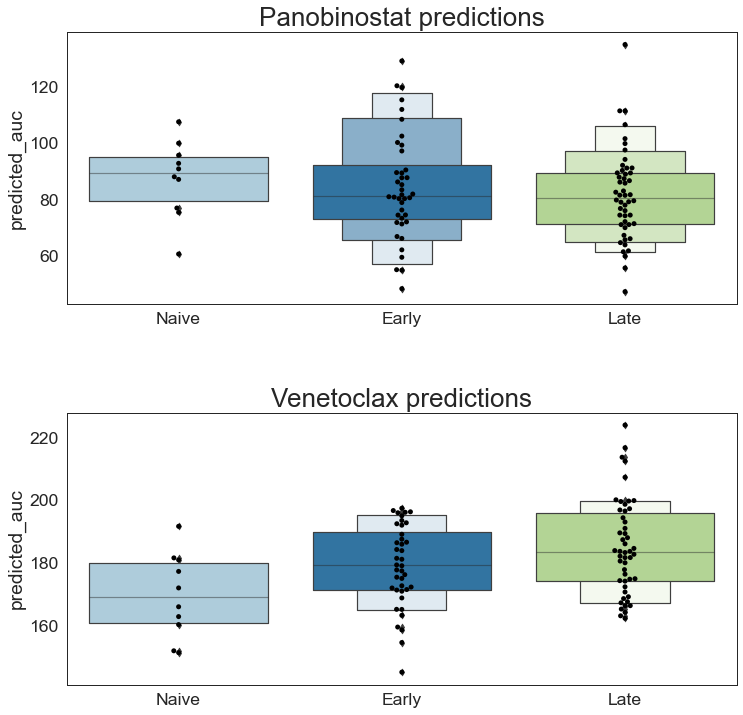

In [18]:
plt.figure(figsize=(12,12))
ax = plt.subplot(211)
plt.title('Panobinostat predictions', fontsize=26)

sns.boxenplot(
    data=pan_cl_results,
    x = 'name', 
    y= 'predicted_auc',
    order=order,
    ax=ax,
    k_depth ='trustworthy',
    scale ='linear',
)
sns.swarmplot(
    data=pan_cl_results,
    x = 'name', 
    y= 'predicted_auc',
    order=order, color='black')
# plt.xticks(rotation=90);

plt.xlabel('')

ax = plt.subplot(212)

sns.boxenplot(
    data=ven_cl_results,
    x = 'name', 
    y= 'predicted_auc',
    ax=ax,
    order=order,
#     k_depth ='trustworthy',
#     scale ='linear',
)




    
sns.swarmplot(
#     data=ven_cl_results.groupby('name').mean().reset_index(),
    data=ven_cl_results,
    x = 'name', 
    y= 'predicted_auc',
    order=order, 
    color='black'
)
plt.xlabel('')
# plt.xticks(rotation=90);
plt.subplots_adjust(hspace=.4)
plt.title('Venetoclax predictions', fontsize=26);
plt.savefig('cell_line_prediction_over_resistnace_merged_late.png', bbox_inches='tight', dpi=300)
plt.savefig('cell_line_prediction_over_resistnace_merged_late.pdf', bbox_inches='tight', dpi=300)

meta NOT subset; don't know how to subset; dropped


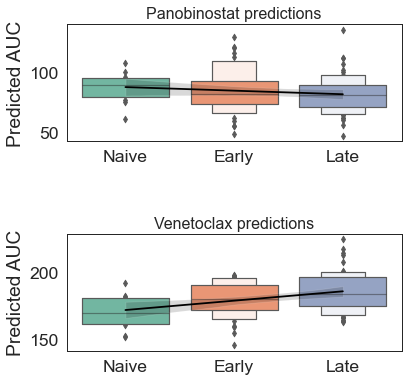

In [19]:
pan_cl_results.loc[pan_cl_results.name == 'Naive', 'count'] = 0
pan_cl_results.loc[pan_cl_results.name == 'Early', 'count'] = 1
pan_cl_results.loc[pan_cl_results.name == 'Late', 'count'] = 2

ven_cl_results.loc[ven_cl_results.name == 'Naive', 'count'] = 0
ven_cl_results.loc[ven_cl_results.name == 'Early', 'count'] = 1
ven_cl_results.loc[ven_cl_results.name == 'Late', 'count'] = 2

sns.set_context("paper", font_scale = 2)
palette = 'Set2'
plt.figure(figsize=(6, 6))
ax = plt.subplot(211)
plt.title('Panobinostat predictions', fontsize=16)
sns.boxenplot(
    data=pan_cl_results,
    x = 'count', 
    y= 'predicted_auc',
    ax=ax,
    palette=palette
)
sns.regplot(
    data=pan_cl_results,
    x = 'count', 
    y= 'predicted_auc',
    ax=ax,
    scatter=False,
    color='black'
)
ax.set(xticks=[0,1,2], xticklabels=['Naive', 'Early', 'Late'])
ax.set(xlabel='')
ax.set(ylabel='Predicted AUC')
ax = plt.subplot(212)

sns.boxenplot(
    data=ven_cl_results,
    x = 'count', 
    y= 'predicted_auc',
    ax=ax,
    palette=palette
)
sns.regplot(
    data=ven_cl_results,
    x = 'count', 
    y= 'predicted_auc',
#     order=order,
    ax=ax,
    scatter=False,
    color='black'
#     k_depth ='trustworthy',
#     scale ='linear',
)

ax.set(xticks=[0,1,2], xticklabels=['Naive', 'Early', 'Late'])
ax.set(xlabel='')
ax.set(ylabel='Predicted AUC')
plt.subplots_adjust(hspace=.8)
plt.title('Venetoclax predictions', fontsize=16);
plt.savefig('cell_line_prediction_over_res_update.png', bbox_inches='tight', dpi=300)
plt.savefig('cell_line_prediction_over_res_update.pdf', bbox_inches='tight', dpi=300)

In [20]:
ven_cl_results['drug'] = 'venetoclax'
pan_cl_results['drug'] = 'panobinostat'
combo = pd.concat([ven_cl_results, pan_cl_results])
combo

,cell_line,predicted_auc,name,count,drug
0,P5.10_FLT3 ligand_Early,192.153709,Early,1.0,venetoclax
1,P5.1_None_Naive,191.798854,Naive,0.0,venetoclax
2,P5.2_None_Naive,181.127755,Naive,0.0,venetoclax
3,P5.3_FGF2_Early,177.634759,Early,1.0,venetoclax
4,P5.4_FGF2_Early,189.275469,Early,1.0,venetoclax
...,...,...,...,...,...
95,P6.5_FGF2_Late,101.655006,Late,2.0,panobinostat
96,P6.6_FGF2_Late,111.492573,Late,2.0,panobinostat
97,P6.7_FLT3 ligand_Late,81.658291,Late,2.0,panobinostat
98,P6.8_FLT3 ligand_Late,91.256161,Late,2.0,panobinostat


[WARNING] C:\Users\pino216\Miniconda3\envs\beatAML_env_37\lib\site-packages\seaborn\categorical.py:1296: UserWarning:

10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


[WARNING] C:\Users\pino216\Miniconda3\envs\beatAML_env_37\lib\site-packages\seaborn\categorical.py:1296: UserWarning:

12.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


[WARNING] C:\Users\pino216\Miniconda3\envs\beatAML_env_37\lib\site-packages\seaborn\categorical.py:1296: UserWarning:

18.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.




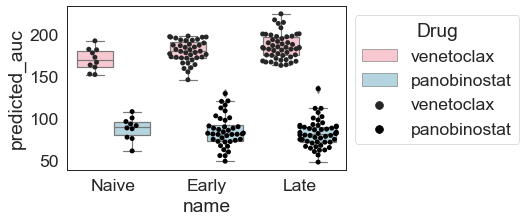

In [21]:
fig = plt.figure(figsize=(5,3))
ax=fig.add_subplot(111) 
ax = sns.boxplot(
    x='name',
    y='predicted_auc',
    hue='drug',
    data=combo, 
    ax=ax,
    palette=['pink', 'lightblue'],
    order = ['Naive', 'Early', 'Late']
)

sns.swarmplot(
#     data=ven_cl_results.groupby('name').mean().reset_index(),
    data=combo,
    x = 'name', 
    y= 'predicted_auc',
    order=['Naive', 'Early', 'Late'], 
    dodge = True,
    hue='drug',
    color='black'
)

hatches = ["||", "--", "|"]
# Loop over the bars
for bars, hatch in zip(ax.containers, hatches):
    # Set a different hatch for each group of bars
    for bar in bars:
        bar.set_hatch(hatch)
ax.legend(title='Drug')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

meta NOT subset; don't know how to subset; dropped


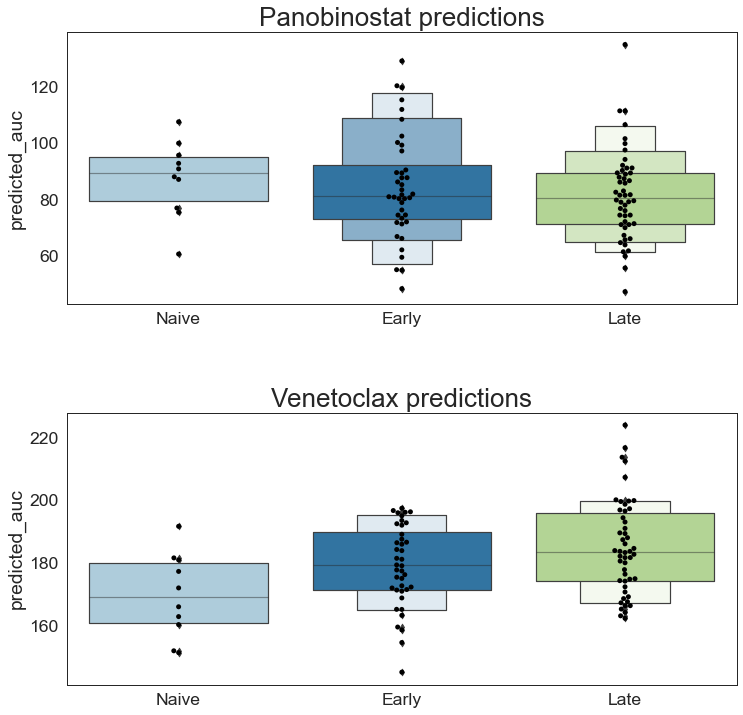

In [22]:
plt.figure(figsize=(12,12))
ax = plt.subplot(211)
plt.title('Panobinostat predictions', fontsize=26)

sns.boxenplot(
    data=pan_cl_results,
    x = 'name', 
    y= 'predicted_auc',
    order=order,
    ax=ax,
    k_depth ='trustworthy',
    scale ='linear',
)
sns.swarmplot(
    data=pan_cl_results,
    x = 'name', 
    y= 'predicted_auc',
    order=order, color='black')
# plt.xticks(rotation=90);

plt.xlabel('')

ax = plt.subplot(212)

sns.boxenplot(
    data=ven_cl_results,
    x = 'name', 
    y= 'predicted_auc',
    ax=ax,
    order=order,
#     k_depth ='trustworthy',
#     scale ='linear',
)




    
sns.swarmplot(
#     data=ven_cl_results.groupby('name').mean().reset_index(),
    data=ven_cl_results,
    x = 'name', 
    y= 'predicted_auc',
    order=order, 
    color='black'
)
plt.xlabel('')
# plt.xticks(rotation=90);
plt.subplots_adjust(hspace=.4)
plt.title('Venetoclax predictions', fontsize=26);
plt.savefig('cell_line_prediction_over_resistnace_merged_late.png', bbox_inches='tight', dpi=300)
plt.savefig('cell_line_prediction_over_resistnace_merged_late.pdf', bbox_inches='tight', dpi=300)

In [23]:
vent_mean = ven_cl_results.groupby('name').mean().reset_index()
vent_mean['auc_mean'] = vent_mean['predicted_auc']/vent_mean.loc[vent_mean.name=='Naive']['predicted_auc'].values[0]*100
vent_mean

,name,predicted_auc,count,auc_mean
0,Early,179.347116,1.0,105.601498
1,Late,185.078771,2.0,108.976358
2,Naive,169.833875,0.0,100.000000


In [24]:
pan_mean = pan_cl_results.groupby('name').mean().reset_index()
pan_mean['auc_mean'] = pan_mean['predicted_auc']/pan_mean.loc[pan_mean.name=='Naive']['predicted_auc'].values[0]*100

In [25]:

pan_mean

,name,predicted_auc,count,auc_mean
0,Early,84.530867,1.0,96.467677
1,Late,81.642632,2.0,93.171587
2,Naive,87.626104,0.0,100.000000


In [26]:
df_subset = data.get_trainable_data(['proteomics', 'phospho'], 'Venetoclax', new_format=True)

merged, cell_line_labels, patient_labels = align_cell_line_to_patients(df_subset.features, qd)

In [27]:
rows = [
    ['fgf2', 'early', 'panobinstat', 54.95],
    ['fgf2', 'late', 'panobinstat', 59.25],
    ['fl', 'early', 'panobinstat', 64.22],
    ['fl', 'late', 'panobinstat', 69.48],
    ['None', 'resistant', 'panobinstat', 46.26],
    ['None', 'naive', 'panobinstat', 142.69],
    ['None', 'resistant', 'venetoclax', 226.07],
    ['None', 'naive', 'venetoclax', 145.24],
    ['fgf2', 'early', 'venetoclax', 238.98],
    ['fgf2', 'late', 'venetoclax', 210.73],
    ['fl', 'early', 'venetoclax', 222.51],
    ['fl', 'late', 'venetoclax', 256.13],
]


In [28]:
exp_auc = pd.DataFrame(rows, columns=['Ligand', 'Stage', 'Drug', 'AUC'])

In [29]:
exp_auc.loc[exp_auc.Stage == 'resistant', 'Stage'] = 'late'

In [30]:
exp_auc

,Ligand,Stage,Drug,AUC
0,fgf2,early,panobinstat,54.95
1,fgf2,late,panobinstat,59.25
2,fl,early,panobinstat,64.22
3,fl,late,panobinstat,69.48
4,None,late,panobinstat,46.26
5,None,naive,panobinstat,142.69
6,None,late,venetoclax,226.07
7,None,naive,venetoclax,145.24
8,fgf2,early,venetoclax,238.98
9,fgf2,late,venetoclax,210.73


meta NOT subset; don't know how to subset; dropped


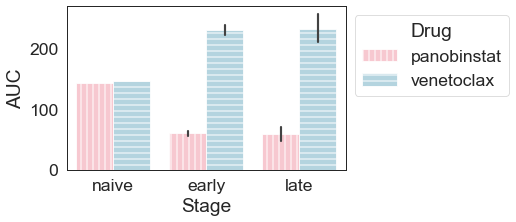

In [31]:
fig = plt.figure(figsize=(5,3))
ax=fig.add_subplot(111) 
ax = sns.barplot(
    x='Stage',
    y='AUC',
    hue='Drug',
    data=exp_auc, 
    ax=ax,
    palette=['pink', 'lightblue'],
    order = ['naive', 'early', 'late']
)

hatches = ["||", "--", "|"]
# Loop over the bars
for bars, hatch in zip(ax.containers, hatches):
    # Set a different hatch for each group of bars
    for bar in bars:
        bar.set_hatch(hatch)
ax.legend(title='Drug')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig('auc_swap_experimental.png', bbox_inches='tight')
plt.savefig('auc_swap_experimental.pdf', bbox_inches='tight')

meta NOT subset; don't know how to subset; dropped


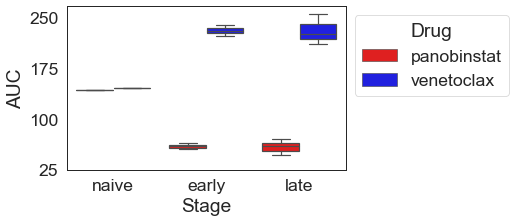

In [32]:
exp_auc.sort_values('Drug', inplace=True)
fig = plt.figure(figsize=(5,3))
ax=fig.add_subplot(111) 
ax = sns.boxplot(
    x='Stage',
    y='AUC',
    hue='Drug',
    data=exp_auc, 
    ax=ax,
    palette=[ 'red', 'blue',],
    order = ['naive', 'early', 'late']
)

hatches = ["||", "--", "|"]
# Loop over the bars
for bars, hatch in zip(ax.containers, hatches):
    # Set a different hatch for each group of bars
    for bar in bars:
        bar.set_hatch(hatch)
ax.legend(title='Drug')
plt.yticks(range(25, 301, 75))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig('auc_swap_experimental.png', bbox_inches='tight')
plt.savefig('auc_swap_experimental.pdf', bbox_inches='tight')

meta NOT subset; don't know how to subset; dropped


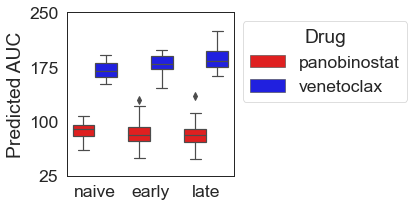

In [33]:
combo.sort_values('drug', inplace=True)
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111) 
ax = sns.boxplot(
    x='name',
    y='predicted_auc',
    hue='drug',
    data=combo, 
    ax=ax,
    palette=['red', 'blue'],
    order = ['Naive', 'Early', 'Late']
)

# sns.swarmplot(
# #     data=ven_cl_results.groupby('name').mean().reset_index(),
#     data=combo,
#     x = 'name', 
#     y= 'predicted_auc',
#     order=['Naive', 'Early', 'Late'], 
#     dodge = True,
#     hue='drug',
#     color='black'
# )

hatches = ["||", "--", "|"]
# Loop over the bars
for bars, hatch in zip(ax.containers, hatches):
    # Set a different hatch for each group of bars
    for bar in bars:
        bar.set_hatch(hatch)
ax.legend(title='Drug')
plt.ylim(25, 250)
plt.yticks(range(25, 301, 75))
plt.xlabel(None)
plt.ylabel('Predicted AUC')
plt.xticks([0, 1,2], ['naive', 'early', 'late'])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig('auc_swap_predicted.png', bbox_inches='tight')
plt.savefig('auc_swap_predicted.pdf', bbox_inches='tight')

meta NOT subset; don't know how to subset; dropped


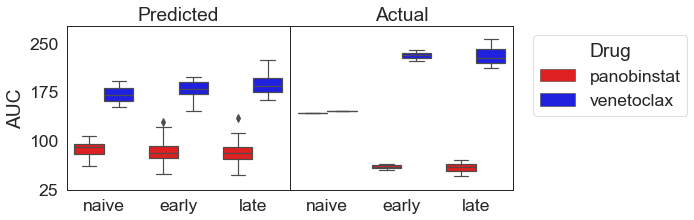

In [34]:
exp_auc.sort_values('Drug', inplace=True)
combo.sort_values('drug', inplace=True)


# fig = plt.figure(figsize=(10, 3))
# ax1 = plt.subplot(121) 
# ax2 = plt.subplot(122, sharey =ax1) 

fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2, 
    sharey='row', 
    figsize=(8,3)
)
ax1 = sns.boxplot(
    x='name',
    y='predicted_auc',
    hue='drug',
    data=combo, 
    ax=ax1,
    palette=['red', 'blue'],
    order = ['Naive', 'Early', 'Late']
)







ax2 = sns.boxplot(
    x='Stage',
    y='AUC',
    hue='Drug',
    data=exp_auc, 
    ax=ax2,
    palette=[ 'red', 'blue',],
    order = ['naive', 'early', 'late'],

)

ax1.set_ylabel('AUC')
ax1.set_xticks([0, 1,2], ['naive', 'early', 'late'])
ax1.legend([],[], frameon=False)
ax1.set_ylim(25, 275)
ax2.set_ylim(25, 275)
ax1.set_yticks(range(25, 301, 75))
ax2.set_yticks(range(25, 301, 75))
ax1.set_xlabel(None)
ax2.set_xlabel(None)
ax2.set_ylabel(None)

ax1.set_title("Predicted")
ax2.set_title("Actual")


plt.subplots_adjust(wspace=0.0,)
# ax1.get_shared_y_axes().join(ax1, ax2)
sns.move_legend(ax2, "upper left", bbox_to_anchor=(1.05, 1))
# plt.tight_layout()

plt.savefig('auc_swap_merged.png', bbox_inches='tight')
plt.savefig('auc_swap_merged.pdf', bbox_inches='tight')

[1.46229540e-01 7.25281041e-02 4.65901793e-02 3.78237873e-02
 3.38718325e-02 2.81292686e-02 2.63230388e-02 2.00847084e-02
 1.97050791e-02 1.73247733e-02 1.56088021e-02 1.54724233e-02
 1.48721082e-02 1.41690943e-02 1.28920645e-02 1.27283514e-02
 1.22673125e-02 1.12430575e-02 1.10265793e-02 1.07634283e-02
 1.02552389e-02 9.72509234e-03 9.47737239e-03 8.93462527e-03
 8.84701890e-03 8.70986182e-03 8.40375073e-03 7.82502246e-03
 7.63390937e-03 7.49467753e-03 7.44762916e-03 7.24089152e-03
 6.91288011e-03 6.71536472e-03 6.57127941e-03 6.35464872e-03
 6.26121165e-03 6.16971231e-03 5.98634590e-03 5.93165019e-03
 5.84718189e-03 5.66966960e-03 5.49655201e-03 5.40248569e-03
 5.26483622e-03 5.15839786e-03 5.04797439e-03 5.00640022e-03
 4.93061839e-03 4.84650710e-03 4.70207593e-03 4.62253811e-03
 4.57114212e-03 4.51911137e-03 4.36375675e-03 4.20694415e-03
 4.13230685e-03 4.01838508e-03 3.99978518e-03 3.86567122e-03
 3.80459892e-03 3.70289283e-03 3.67003276e-03 3.60524152e-03
 3.55894944e-03 3.495583

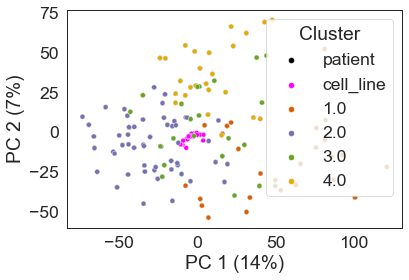

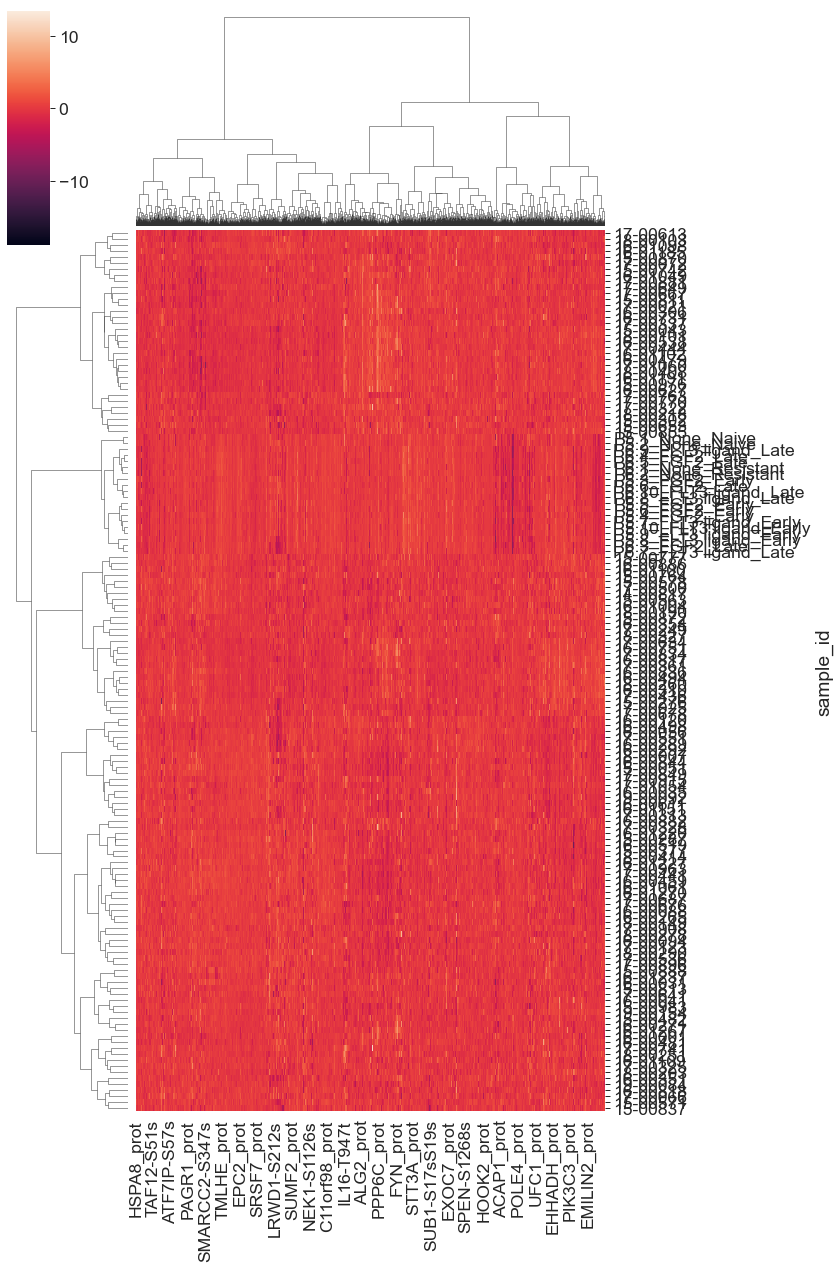

In [35]:
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from mpl_toolkits.axes_grid1 import make_axes_locatable
import umap

def make_umap_dataset(feature_matrix):
#     feature_matrix = feature_matrix[set(feature_matrix.columns.values).intersection(selected_drugs.index.values)]
    umap_scaled = StandardScaler().fit_transform(feature_matrix.fillna(0))
#     reducer = umap.UMAP(
#     #     n_neighbors=10,
#         n_components=2,
#     #     metric='correlation'

#     )
    reducer = PCA()
    X_embedded = reducer.fit_transform(umap_scaled)
    
    print(reducer.explained_variance_ratio_)
    
    principalDf = pd.DataFrame(
        data = X_embedded,
        columns = [f'pc{i}' for i in range(1, X_embedded.shape[1]+1)],
        index=feature_matrix.index
    )

    umap_df = pd.concat([principalDf, data.meta['Cluster']], axis = 1)
#     umap_df.dropna(subset=['Venetoclax', 'Panobinostat'],  inplace=True)
    return umap_df


umap_df = make_umap_dataset(merged)
umap_df.loc[cell_line_labels, 'source'] = 'cell_line'
umap_df.loc[patient_labels, 'source'] = 'patient'

g1 = sns.scatterplot(
    data=umap_df,
    x='pc1', y='pc2', 
    hue='source',
    palette=['black', 'magenta']
#     palette=cluster_colors,
#     ax=ax1
)
g1 = sns.scatterplot(
    data=umap_df,
    x='pc1', y='pc2', 
    hue='Cluster',
    palette=cluster_colors,
#     ax=ax1
)
plt.xlabel('PC 1 (14%)')
plt.ylabel('PC 2 (7%)')
#plt.savefig('pca_w_cell_line.pdf', bbox_inches='tight')

sns.clustermap(
    merged.fillna(0), 
    method='ward',
    metric='correlation',
    z_score=0,
    yticklabels=True,
    figsize=(12,18)
#     mask=merged.isnull()
)